In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import json
from wordcloud import WordCloud
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
stopwords = stopwords.words("english")

from nltk.stem import PorterStemmer
from nltk import word_tokenize,sent_tokenize

from imblearn.over_sampling import SMOTE

from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout, SimpleRNN

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import pickle

In [2]:
train_data = pd.read_csv('TRAIN_DATA.csv')
test_data = pd.read_csv('TEST_DATA.csv')
val_data = pd.read_csv('VAL_DATA.csv')

In [3]:
train_data.head()

,Sentence,Emotion,Length
0,My favourite food is anything I didn't have to...,6,59
1,"Now if he does off himself, everyone will thin...",6,112
2,WHY THE FUCK IS BAYLESS ISOING,0,30
3,To make her feel threatened,2,27
4,Dirty Southern Wankers,0,22


In [129]:
train_data['Emotion'].unique()

array([6, 0, 2, 5, 3, 4, 1], dtype=int64)

In [4]:
val_data.head()

,Sentence,Emotion
0,Is this in New Orleans?? I really feel like th...,6
1,"You know the answer man, you are programmed to...",3
2,I've never been this sad in my life!,4
3,The economy is heavily controlled and subsidiz...,3
4,He could have easily taken a real camera from ...,3


# DATA CLEANING

In [195]:
# Data Cleaning
print(len(stopwords))

# Max length of senetence
max_len = train_data["Length"].max()
print(max_len)

179
703


In [197]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data)

In [199]:
vocabsize = 18000   #20-12551 #30-15000 43-17555
vocabsize = int(vocabsize * 5 )
print(vocabsize)

90000


In [201]:
def text_cleaning(df, column):
    stemmer = PorterStemmer()
    corpus = []
    
    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)
    # Split each sentence into a list of words and flatten the list of lists into a single list
    words = [word.lower() for sentence in corpus for word in nltk.word_tokenize(sentence)]

    # Convert the list of words into a set to remove duplicates and find the number of unique words
    unique_words = set(words)
    num_unique_words = len(unique_words)

    print(f"Number of unique words: {num_unique_words}")
    one_hot_word = [one_hot(input_text=word, n=vocabsize) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding="pre")
    print(pad.shape)
    return pad

In [203]:
X_train = text_cleaning(train_data, "Sentence")
X_test = text_cleaning(test_data, "Sentence")
X_val = text_cleaning(val_data, "Sentence")

Number of unique words: 17555
(43227, 703)
Number of unique words: 6167
(5421, 703)
Number of unique words: 6237
(5421, 703)


In [204]:
y_train = train_data["Emotion"]
y_test = test_data["Emotion"]
y_val = val_data["Emotion"]

In [205]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)
y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [206]:
smote = SMOTE(sampling_strategy='minority')
X_train, y_train = smote.fit_resample(X_train, y_train)

In [207]:
smote = SMOTE(sampling_strategy='minority')
X_test, y_test = smote.fit_resample(X_test, y_test)
y_test.shape

(7386, 7)

In [208]:
smote = SMOTE(sampling_strategy='minority')
X_val, y_val = smote.fit_resample(X_val, y_val)

# MODEL

In [17]:
# Model creation
model = Sequential()
model.add(Embedding(input_dim=vocabsize, output_dim=300, input_length=max_len)) 
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences=True))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(60, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='sigmoid')) 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.build(input_shape=(None, max_len))  
model.summary()


C:\Users\ssttg\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 703, 300)       │    27,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 703, 300)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 703, 512)       │     1,665,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 60)             │        15,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           427 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,468,327 (112.41 MB)

 Trainable params: 29,468,327 (112.41 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [19]:
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

In [20]:
hist = model.fit(X_train, y_train, epochs=12, validation_data=(X_val, y_val), callbacks=[callback])

Epoch 1/12
1859/1859 ━━━━━━━━━━━━━━━━━━━━ 6761s 4s/step - accuracy: 0.3664 - loss: 1.5325 - val_accuracy: 0.6669 - val_loss: 0.9491
Epoch 2/12
1859/1859 ━━━━━━━━━━━━━━━━━━━━ 28334s 15s/step - accuracy: 0.6699 - loss: 0.9320 - val_accuracy: 0.6828 - val_loss: 0.8947
Epoch 3/12
1859/1859 ━━━━━━━━━━━━━━━━━━━━ 7211s 4s/step - accuracy: 0.7033 - loss: 0.8320 - val_accuracy: 0.6972 - val_loss: 0.8467
Epoch 4/12
1859/1859 ━━━━━━━━━━━━━━━━━━━━ 15586s 8s/step - accuracy: 0.7442 - loss: 0.7280 - val_accuracy: 0.6929 - val_loss: 0.8894
Epoch 5/12
1859/1859 ━━━━━━━━━━━━━━━━━━━━ 7609s 4s/step - accuracy: 0.7750 - loss: 0.6455 - val_accuracy: 0.6878 - val_loss: 0.8974


In [41]:
model.evaluate(X_test, y_test)

231/231 ━━━━━━━━━━━━━━━━━━━━ 413s 2s/step - accuracy: 0.6055 - loss: 1.1204


[0.8829977512359619, 0.6881938576698303]

In [43]:
pred = model.predict(X_test)

231/231 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step


In [52]:
pred

array([[0.37584767, 0.01971132, 0.13007194, ..., 0.74024117, 0.4406371 ,
        0.47272384],
       [0.62015814, 0.75557804, 0.45069525, ..., 0.13361669, 0.14106774,
        0.42371467],
       [0.37231138, 0.01543107, 0.02527036, ..., 0.11354309, 0.4195484 ,
        0.5963285 ],
       ...,
       [0.22687013, 0.99908334, 0.05950961, ..., 0.00523254, 0.04806168,
        0.30952317],
       [0.3412437 , 0.99695325, 0.06608543, ..., 0.00894966, 0.08109707,
        0.47927257],
       [0.44456452, 0.9841404 , 0.06772157, ..., 0.02112914, 0.14791334,
        0.6676791 ]], dtype=float32)

In [54]:
y_test

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

# Evaluting Model Hist

### Long Short-Term Memory (LSTM)

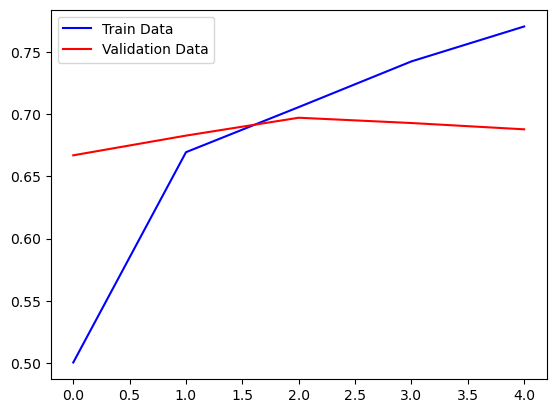

In [82]:
plt.plot(hist.history["accuracy"], "b", label="Train Data")
plt.plot(hist.history["val_accuracy"], "r", label="Validation Data")
plt.legend()
plt.show()

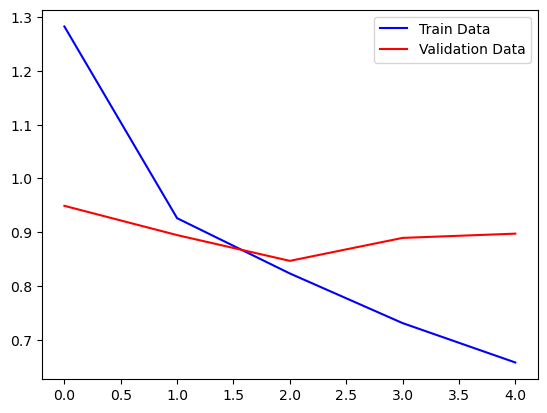

In [84]:
plt.plot(hist.history["loss"], "b", label="Train Data")
plt.plot(hist.history["val_loss"], "r", label="Validation Data")
plt.legend()
plt.show()

In [56]:
pred.argmax(axis=-1)

array([4, 1, 3, ..., 1, 1, 1], dtype=int64)

In [58]:
y_pred = pred.argmax(axis=-1)
y_test = y_test.argmax(axis=-1)

In [62]:
def plot_confusion_matrix(y_test, y_pred):
    # Create a confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Create a heatmap of the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r')
    
    # Label the plot
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # Show the plot
    plt.show()

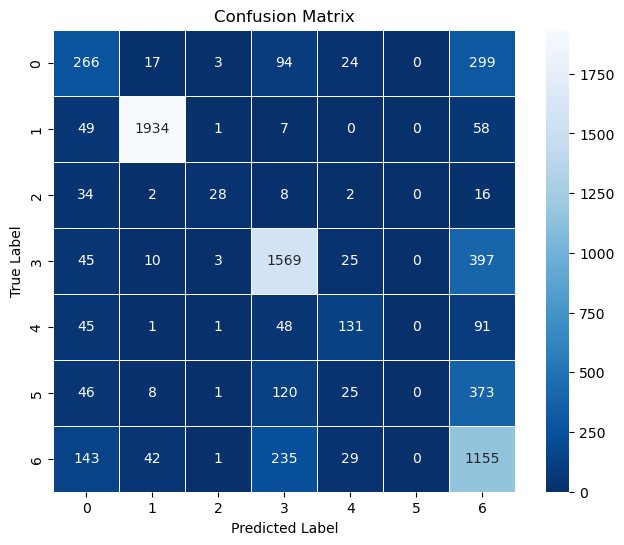

In [64]:
plot_confusion_matrix(y_test, y_pred)

In [66]:
print(classification_report(y_test, y_pred, zero_division='warn'))

              precision    recall  f1-score   support

           0       0.42      0.38      0.40       703
           1       0.96      0.94      0.95      2049
           2       0.74      0.31      0.44        90
           3       0.75      0.77      0.76      2049
           4       0.56      0.41      0.47       317
           5       0.00      0.00      0.00       573
           6       0.48      0.72      0.58      1605

    accuracy                           0.69      7386
   macro avg       0.56      0.50      0.51      7386
weighted avg       0.65      0.69      0.66      7386



C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [68]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")

# Print the results
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

Accuracy:  0.6881938803141078
Precision:  0.5590288727302919
Recall:  0.5045684735916443
F1-score:  0.5144512304204618


C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [74]:
print(hist)

In [72]:
model

<Sequential name=sequential, built=True>

In [76]:
#model.save('trained_model_1.h5')

In [80]:
#with open('training_history_of_model1.pkl', 'wb') as f:
#    pickle.dump(hist.history, f)

# Let's Predict

In [111]:
def clean_new_text(text, vocabsize, max_len):
    """Preprocess and clean a new sentence for prediction"""
    # Clean and preprocess the text (similar to training)
    stemmer = PorterStemmer()
    
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    words = text.split()
    
    words = [stemmer.stem(word) for word in words if word not in stopwords]
    cleaned_text = " ".join(words)
    
    # One-hot encode and pad the cleaned sentence
    one_hot_word = one_hot(input_text=cleaned_text, n=vocabsize)
    padded_sequence = pad_sequences([one_hot_word], maxlen=max_len, padding="pre")
    
    return padded_sequence

In [ ]:
def text_cleaning(df, column):
    stemmer = PorterStemmer()
    corpus = []
    
    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)
    # Split each sentence into a list of words and flatten the list of lists into a single list
    words = [word.lower() for sentence in corpus for word in nltk.word_tokenize(sentence)]

    # Convert the list of words into a set to remove duplicates and find the number of unique words
    unique_words = set(words)
    num_unique_words = len(unique_words)

    print(f"Number of unique words: {num_unique_words}")
    one_hot_word = [one_hot(input_text=word, n=vocabsize) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding="pre")
    print(pad.shape)
    return pad

In [137]:
def predict_emotion(new_sentence, model, vocabsize, max_len):
    """Predict the emotion of a new sentence using the trained model"""
    # Clean and preprocess the input sentence
    processed_sentence = clean_new_text(new_sentence, vocabsize, max_len)
    
    # Make a prediction
    prediction = model.predict(processed_sentence)
    predicted_class = prediction.argmax(axis=1)[0]
    
    # Get the predicted emotion label
    predicted_emotion = emotion_labels[predicted_class]
    
    
    return predicted_emotion

In [156]:
new_sentence = "I've never been this sad in my life!	"

In [158]:
vocabsize = 18000  # Set this to the actual vocabsize used during training
max_len = 703  # Set this to the max_len used during training

emotion_labels = ["Anger", "Disgust", "Fear", "Happiness", "Sadness", "Surprise", "Neutral"]

# Predict the emotion for your new sentence
predicted_emotion = predict_emotion(new_sentence, model, vocabsize, max_len)
print(f"Predicted Emotion: {predicted_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
Predicted Emotion: Disgust


# Bi-Lstm

In [215]:
print("Max index in y_train:", np.max(y_train))
print("Max index in X_train:", np.max(X_train))


Max index in y_train: 1
Max index in X_train: 89997


In [217]:
vocabsize

90000

In [219]:
model = Sequential()
model.add(Embedding(input_dim=vocabsize, output_dim=800, input_length=max_len))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(512, return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(256)))
model.add(Dropout(0.2))

model.add(Dense(60, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(7, activation="softmax"))

model.build(input_shape=(None, max_len))

model.summary()

C:\Users\ssttg\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 703, 800)       │    72,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 703, 800)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 703, 1024)      │     5,378,048 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 703, 1024)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 512)            │     2,623,488 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 60)             │        30,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 7)              │           427 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,032,743 (305.30 MB)

 Trainable params: 80,032,743 (305.30 MB)

 Non-trainable params: 0 (0.00 B)

In [221]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [223]:
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

In [ ]:
hist_2 = model.fit(X_train, y_train, epochs=12, validation_data=(X_val, y_val), callbacks=[callback])

Epoch 1/12
 892/1859 ━━━━━━━━━━━━━━━━━━━━ 5:42:57 21s/step - accuracy: 0.7151 - loss: 0.7898